In [ ]:
# ==========================================
# SETUP BLOCK
# ==========================================

import os
import sys
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

from pandas.api.types import CategoricalDtype
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans

sys.path.append(os.path.abspath(".."))

from Helper_functions import (
    clean_up_subjects,
    calculate_true_false_score,
    calculate_internet_terms_understanding_score,
    group_internet_understanding,
)

from lists import (
    demographic_columns,
    multiple_choice_questions,
    likert_questions,
    LIKERT_VALUE_MAPS,
)

from answer_categories import question_orders, COLUMN_ALIASES

sns.set(style="whitegrid")
plt.rcParams["figure.figsize"] = (10, 5)

DATA_FILE = os.path.join("..", "Data", "Fertige Tabelle.xlsx")
df = pd.read_excel(DATA_FILE)
df.columns = df.columns.astype(str).str.strip()
df = df.rename(columns=COLUMN_ALIASES)

for col in ["Most used subjects", "Preferred Subjects", "Least preferred Subjects"]:
    if col in df.columns:
        df = clean_up_subjects(df, col)

true_false_cols = [f"True/False_{i}" for i in range(1, 7)]
if all(c in df.columns for c in true_false_cols):
    df = calculate_true_false_score(df)

if any(c.startswith("Internet terms_") for c in df.columns):
    df = calculate_internet_terms_understanding_score(df)
    df = group_internet_understanding(df)

print("Setup complete – DataFrame loaded and preprocessed")
print(f"Rows: {len(df)}, Columns: {len(df.columns)}")


Cluster file written to: ../Data/Clustered_Students_Final.xlsx
Number of students in cluster analysis: 178
Cluster
A    57
B    63
C    58
Name: count, dtype: int64


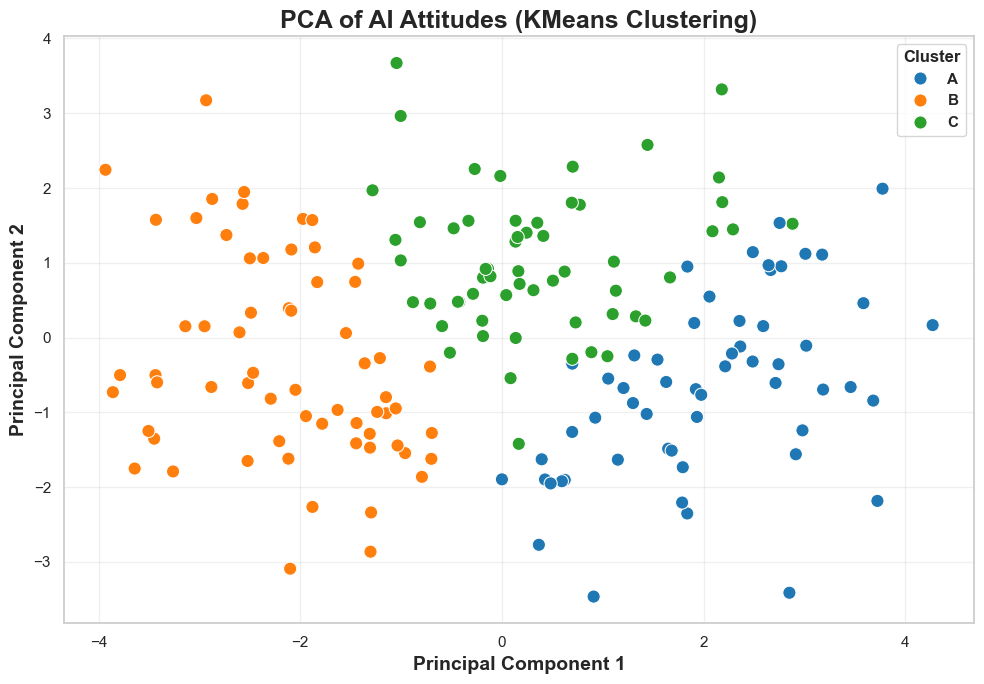

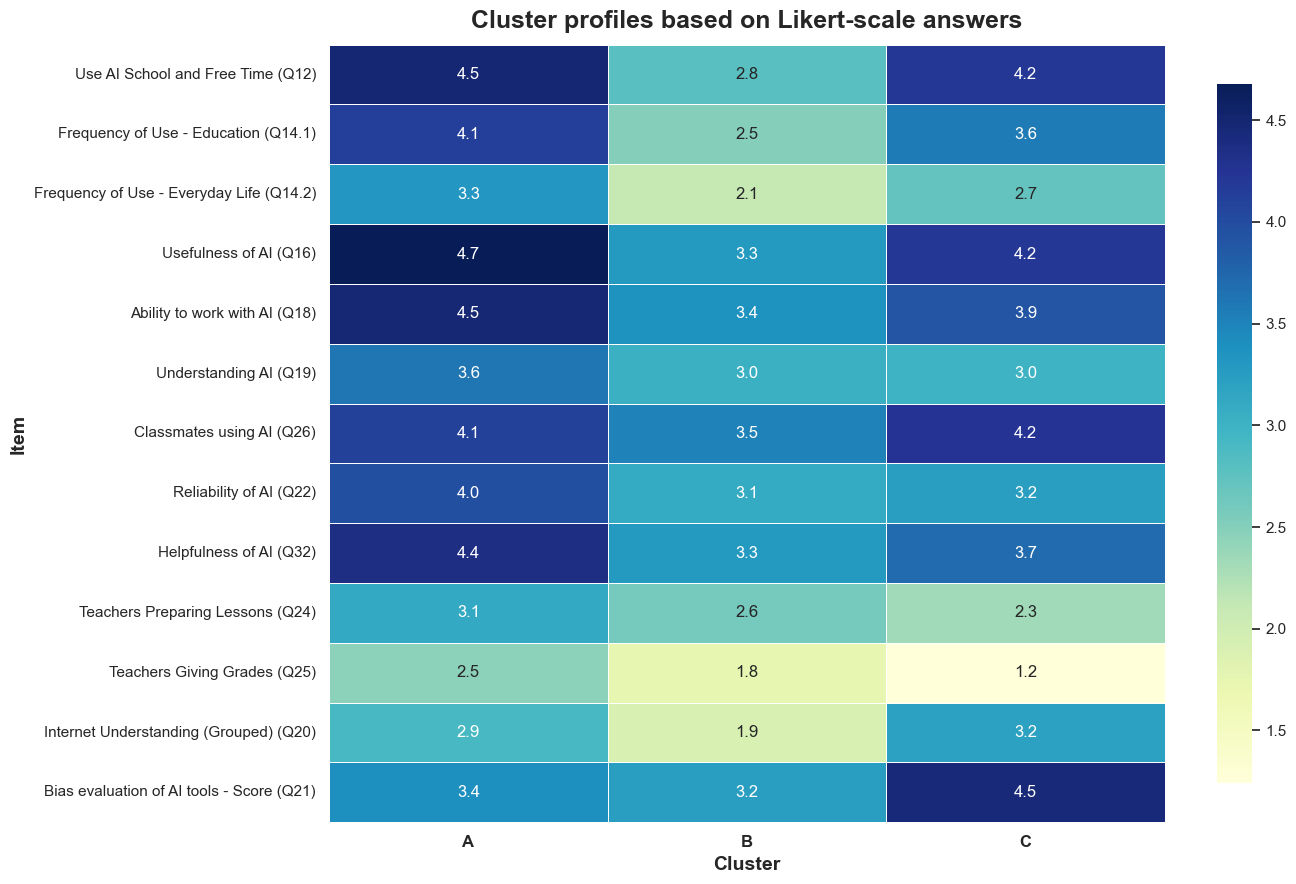

In [24]:
# ==========================================
# CLUSTER CREATION
# KMEANS ON FULL SCALED DATA
# PCA ONLY FOR VISUALIZATION
# EXCEL EXPORT FOR DOCUMENTATION
# ==========================================

np.random.seed(42)
os.makedirs("../Data", exist_ok=True)

# ------------------------------------------
# 1) Filter complete cases for clustering
# ------------------------------------------

df_clean = df.dropna(subset=likert_questions).copy()


df_clean = df_clean[df_clean["Use AI school and freetime"] != "Nie"]

# ------------------------------------------
# 2) Convert Likert items to numeric
# ------------------------------------------

df_numeric = pd.DataFrame(index=df_clean.index)

for col in likert_questions:
    s = df_clean[col]
    if col in LIKERT_VALUE_MAPS:
        mapped = s.astype("string").str.strip().map(LIKERT_VALUE_MAPS[col])
        df_numeric[col] = pd.to_numeric(mapped, errors="coerce")
    else:
        df_numeric[col] = pd.to_numeric(s, errors="coerce")

df_numeric = df_numeric.dropna()
df_clean = df_clean.loc[df_numeric.index].copy()

# ------------------------------------------
# 3) Standardization
# ------------------------------------------

scaler = StandardScaler()
scaled_data = scaler.fit_transform(df_numeric)

# ------------------------------------------
# 4) K-Means clustering 
# ------------------------------------------

kmeans = KMeans(
    n_clusters=3,
    n_init=10,
    random_state=42
)

cluster_num = kmeans.fit_predict(scaled_data)

cluster_map = {0: "B", 1: "A", 2: "C"}

df_clean["Cluster_num"] = cluster_num
df_clean["Cluster"] = df_clean["Cluster_num"].map(cluster_map)

cat_type = CategoricalDtype(categories=["A", "B", "C"], ordered=True)
df_clean["Cluster"] = df_clean["Cluster"].astype(cat_type)

# ------------------------------------------
# 5) PCA for visualization ONLY
# ------------------------------------------

pca = PCA(n_components=2, random_state=42)
pca_result = pca.fit_transform(scaled_data)

df_clean["PC1"] = pca_result[:, 0]
df_clean["PC2"] = pca_result[:, 1]

# ------------------------------------------
# 6) EXPORT cluster results to Excel
# ------------------------------------------

cluster_export_file = "../Data/Clustered_Students_Final.xlsx"

with pd.ExcelWriter(cluster_export_file, engine="xlsxwriter") as writer:
    df_clean.to_excel(writer, sheet_name="All_Clustered_Students", index=False)

    for c in ["A", "B", "C"]:
        df_clean[df_clean["Cluster"] == c].to_excel(
            writer,
            sheet_name=f"Cluster_{c}",
            index=False
        )

print(f"Cluster file written to: {cluster_export_file}")
print("Number of students in cluster analysis:", len(df_clean))
print(df_clean["Cluster"].value_counts().sort_index())

# ==========================================
# 7) PLOTS: PCA SCATTER + HEATMAP
# Uses df_clean (with Cluster, PC1, PC2) and df_numeric
# ==========================================

os.makedirs("figures", exist_ok=True)

# -----------------------------
# PCA scatterplot (student map)
# -----------------------------
fig, ax = plt.subplots(figsize=(10, 7))

sns.scatterplot(
    data=df_clean,
    x="PC1",
    y="PC2",
    hue="Cluster",
    hue_order=["A", "B", "C"],
    palette="tab10",
    s=90,
    ax=ax
)

ax.set_title("PCA of AI Attitudes (KMeans Clustering)", fontsize=18, fontweight="bold")
ax.set_xlabel("Principal Component 1", fontsize=14, fontweight="bold")
ax.set_ylabel("Principal Component 2", fontsize=14, fontweight="bold")
ax.grid(True, alpha=0.3)

leg = ax.legend(title="Cluster", loc="best")
plt.setp(leg.get_texts(), fontsize=11, fontweight="bold")
plt.setp(leg.get_title(), fontsize=12, fontweight="bold")

fig.tight_layout()
fig.savefig("figures/pca_kmeans_clusters.pdf", bbox_inches="tight")
plt.show()
plt.close(fig)

# -----------------------------
# Heatmap of cluster means
# -----------------------------
cluster_means = (
    df_numeric.assign(Cluster=df_clean["Cluster"])
    .groupby("Cluster", observed=True)
    .mean()
    .reindex(["A", "B", "C"])
    .round(2)
)

row_rename_map = {
    "Use AI school and freetime": "Use AI School and Free Time (Q12)",
    "Frequency of use education": "Frequency of Use - Education (Q14.1)",
    "Frequency of use everyday life": "Frequency of Use - Everyday Life (Q14.2)",
    "Usefulness AI": "Usefulness of AI (Q16)",
    "Deal with AI": "Ability to work with AI (Q18)",
    "Understanding AI": "Understanding AI (Q19)",
    "Reliability AI": "Reliability of AI (Q22)",
    "Help of AI": "Helpfulness of AI (Q32)",
    "Mates using AI": "Classmates using AI (Q26)",
    "Teachers preparing lessons": "Teachers Preparing Lessons (Q24)",
    "Teachers giving grades": "Teachers Giving Grades (Q25)",
    "Internet Understanding (Grouped)": "Internet Understanding (Grouped) (Q20)",
    "True_False_Score": "Bias evaluation of AI tools - Score (Q21)",
}

heat_df = cluster_means.T.rename(index=row_rename_map)

name_understanding = row_rename_map.get("Understanding AI", "Understanding AI")
name_mates = row_rename_map.get("Mates using AI", "Mates using AI")

order = list(heat_df.index)
if name_mates in order and name_understanding in order:
    order.remove(name_mates)
    order.insert(order.index(name_understanding) + 1, name_mates)
    heat_df = heat_df.loc[order]

fig, ax = plt.subplots(figsize=(14, 9))

sns.heatmap(
    heat_df[["A", "B", "C"]],
    annot=True,
    fmt=".1f",
    cmap="YlGnBu",
    linewidths=0.5,
    cbar=True,
    cbar_kws={"shrink": 0.9},
    ax=ax
)

ax.set_title("Cluster profiles based on Likert-scale answers", fontsize=18, fontweight="bold", pad=12)
ax.set_xlabel("Cluster", fontsize=14, fontweight="bold")
ax.set_ylabel("Item", fontsize=14, fontweight="bold")

ax.set_xticklabels(ax.get_xticklabels(), fontsize=12, fontweight="bold", rotation=0)
ax.set_yticklabels(ax.get_yticklabels(), fontsize=11, rotation=0)

fig.tight_layout()
fig.savefig("figures/cluster_profiles_heatmap.pdf", bbox_inches="tight")
plt.show()
plt.close(fig)


In [ ]:
# ==========================================
# CLUSTER ANALYSIS 
# Uses df_clean and df_total (optional reference)
# No automatic plot spam
# ==========================================

# -----------------------------
# Preconditions
# -----------------------------
if "Cluster" not in df_clean.columns:
    raise ValueError("df_clean must contain a 'Cluster' column. Run clustering first.")

# Ensure cluster order A,B,C
cat_type = CategoricalDtype(categories=["A", "B", "C"], ordered=True)
df_clean["Cluster"] = df_clean["Cluster"].astype(cat_type)

# ==========================================
# 1) Cluster sizes
# ==========================================
cluster_sizes = pd.DataFrame({
    "n": df_clean["Cluster"].value_counts().sort_index(),
    "%": (df_clean["Cluster"].value_counts(normalize=True) * 100).sort_index().round(1)
})

print("\n=== Cluster sizes ===")
print(cluster_sizes)

# ==========================================
# Helpers
# ==========================================
def _to_str_clean(series: pd.Series) -> pd.Series:
    return (
        series.dropna()
        .astype("string")
        .str.strip()
        .replace({"": pd.NA})
        .dropna()
    )

def _explode_mc(series: pd.Series) -> pd.Series:
    s = (
        series.dropna()
        .astype("string")
        .str.strip()
        .replace({"": pd.NA})
        .dropna()
    )
    s = s.str.split(",").explode().astype("string").str.strip()
    s = s.replace({"": pd.NA}).dropna()
    return s

def _apply_order(df_in: pd.DataFrame, col: str) -> pd.DataFrame:
    # Use question_orders if available
    if "question_orders" in globals() and col in question_orders:
        desired = [str(v) for v in question_orders[col]]
        idx = df_in.index.astype("string")
        want = [v for v in desired if v in idx.tolist()]
        rest = [v for v in idx.tolist() if v not in want]
        out = df_in.copy()
        out.index = out.index.astype("string")
        return out.reindex(want + rest)

    # Numeric-like sorting if possible
    idx = df_in.index.astype("string")
    if idx.str.fullmatch(r"-?\d+(\.\d+)?").all():
        return df_in.sort_index(key=lambda x: x.astype(float))

    return df_in

def make_cluster_tables(df_data: pd.DataFrame, col: str, multiple_choice: bool) -> tuple[pd.DataFrame, pd.DataFrame]:
    """
    Returns:
      1) within_cluster: distribution within each cluster (n and %)
      2) category_capture: share of each category that falls into each cluster (n and %)
    All computed on df_data (clustered students only).
    """
    # Total counts over clustered sample (not whole dataset)
    total_series = _explode_mc(df_data[col]) if multiple_choice else _to_str_clean(df_data[col])
    total_counts = total_series.value_counts(dropna=False)

    # Per cluster counts
    per_cluster_counts = {}
    for c in ["A", "B", "C"]:
        df_c = df_data[df_data["Cluster"] == c]
        s_c = _explode_mc(df_c[col]) if multiple_choice else _to_str_clean(df_c[col])
        per_cluster_counts[c] = s_c.value_counts(dropna=False).reindex(total_counts.index).fillna(0).astype(int)

    # Within-cluster table
    within_cluster = pd.DataFrame({f"{c} n": per_cluster_counts[c] for c in ["A", "B", "C"]})
    for c in ["A", "B", "C"]:
        denom = within_cluster[f"{c} n"].sum()
        within_cluster[f"{c} % (within cluster)"] = (
            (within_cluster[f"{c} n"] / denom * 100).round(1) if denom > 0 else 0.0
        )

    # Category capture table
    category_capture = pd.DataFrame({"Total n (clustered sample)": total_counts.astype(int)})
    for c in ["A", "B", "C"]:
        category_capture[f"{c} n"] = per_cluster_counts[c]

    denom = category_capture["Total n (clustered sample)"].replace(0, np.nan)
    for c in ["A", "B", "C"]:
        category_capture[f"{c} % of category"] = (category_capture[f"{c} n"] / denom * 100).fillna(0).round(1)

    within_cluster = _apply_order(within_cluster, col)
    category_capture = _apply_order(category_capture, col)

    return within_cluster, category_capture

# ==========================================
# 2) Build all cluster tables (in memory)
# ==========================================
cluster_tables = {}

print("\n=== Demographics by cluster (clustered students only) ===")
for col in demographic_columns:
    if col not in df_clean.columns:
        print(f"Skipping '{col}' (not in df_clean)")
        continue

    mc = col in multiple_choice_questions
    within_tbl, capture_tbl = make_cluster_tables(df_clean, col, multiple_choice=mc)

    cluster_tables[col] = {
        "within_cluster": within_tbl,
        "category_capture": capture_tbl
    }

    print(f"\n--- {col}: within-cluster distribution ---")
    print(within_tbl)

    print(f"\n--- {col}: category capture ---")
    print(capture_tbl)

# ==========================================
# 3) Optional: ONE useful plot (Age composition)
# ==========================================
if "Age" in df_clean.columns:
    tmp = df_clean.copy()
    tmp["Age"] = pd.to_numeric(tmp["Age"], errors="coerce")
    tmp = tmp.dropna(subset=["Age"])

    age_ct = pd.crosstab(tmp["Age"], tmp["Cluster"]).reindex(columns=["A", "B", "C"], fill_value=0).sort_index()
    age_pct = age_ct.div(age_ct.sum(axis=1), axis=0) * 100

    fig, ax = plt.subplots(figsize=(10, 5))
    age_pct.plot(kind="bar", stacked=True, ax=ax)
    ax.set_title("Cluster composition by age (percent within age)")
    ax.set_xlabel("Age")
    ax.set_ylabel("Percent (%)")
    ax.legend(title="Cluster", loc="upper right")
    fig.tight_layout()
    plt.show()
    plt.close(fig)


In [ ]:
import os
import pandas as pd
import matplotlib.pyplot as plt

usage_map = {
    "Nie": "Never",
    "Seltener": "Rarely",
    "Etwa 1 Mal pro Woche": "About once per week",
    "Mehrmals pro Woche": "Several times per week",
    "Täglich": "Daily",
}

plot_df = df.copy()
plot_df["Age"] = pd.to_numeric(plot_df["Age"], errors="coerce")
plot_df["Usage"] = plot_df["Use AI school and freetime"].map(usage_map)
plot_df = plot_df.dropna(subset=["Age", "Usage"])

usage_order = ["Never","Rarely","About once per week","Several times per week","Daily"]

ct = (
    pd.crosstab(plot_df["Age"], plot_df["Usage"])
    .reindex(columns=usage_order, fill_value=0)
    .sort_index()
)

blue_colors = ["#deebf7","#9ecae1","#6baed6","#3182bd","#08519c"]

ct_plot = ct[usage_order[::-1]]
colors_plot = blue_colors[::-1]

ax = ct_plot.plot(kind="bar", stacked=True, figsize=(12, 6), color=colors_plot)

ax.set_title("AI usage (school + free time) by age")
ax.set_xlabel("Age")
ax.set_ylabel("Number of respondents")
ax.legend(title="Usage frequency", loc="upper right")

fig = ax.get_figure()
handles, labels = ax.get_legend_handles_labels()
ax.legend(
    handles[::-1],
    labels[::-1],
    title="Usage frequency",
    loc="upper right"
)

fig.tight_layout()

os.makedirs("figures", exist_ok=True)
fig.savefig("figures/ai_usage_school_vs_life.pdf", bbox_inches="tight")

plt.show()
plt.close(fig)